In [2]:
%matplotlib notebook

## IMPORTS
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
import os
import imghdr
from PIL import Image

from torch.utils.data import Dataset, DataLoader

device = torch.device('mps')

In [3]:
## SET DATASET
DATASET_PATH = "../../../../henrychen/Downloads/dataset/"
path, folders, files = [*os.walk(DATASET_PATH)][0]
CATEGORIES = folders
allowed_types = ["jpg","jpeg"]

In [4]:
def encode_onehot(label, cats):
    enc = np.zeros(len(cats), dtype="float32")
    idx = cats.index(label)
    enc[idx] = 1;
    return enc

def decode_onehot(onehot, cats):
    idx = np.argmax(onehot)
    return cats[idx]

In [ ]:
## REMOVE IMAGES
def get_image(path):
    return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

## IDENTIFY AND DELETE FAILED FILES (DONT TOUCH)
for category in CATEGORIES:
    FOLDER_PATH = f"{DATASET_PATH}/{category}"
    files = os.listdir(f"{DATASET_PATH}/{category}")

    for file in files: 
        PATH = f"{FOLDER_PATH}/{file}"
        file_type = imghdr.what(PATH)

        try: 
            if (file_type in allowed_types):
                
                img = get_image(PATH)

            else: 
                print("error...")
                raise Exception("Sorry, File Not Allowed")
            
        except: 
            os.remove(PATH)
            print(f'{file} failed and Removed')

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataset_path):        
        
        self.paths = []
        self.labels = []
        self.transform = transforms
        
        walks = os.walk(dataset_path)
        
        for path, folders, items in [*walks][1:]:
            for file_path in map(lambda x: f'{path}/{x}', [*items]):
                self.paths.append(file_path)
                self.labels.append(path.split('/')[-1])
                
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        path = self.paths[index]
        img = get_image(path)

        label = encode_onehot(self.labels[index], CATEGORIES)
        tx = Image.fromarray(img)
        tx = transforms.Resize((300,300))(tx)
        tx = transforms.ToTensor()(tx)
        
        return (tx, label)

dataset = ImageDataset(DATASET_PATH)

TRAIN_SIZE = int(len(dataset) * 0.7)
TEST_SIZE = len(dataset) - TRAIN_SIZE

train_set, test_set = torch.utils.data.random_split(dataset,[TRAIN_SIZE,TEST_SIZE])

train_loader = DataLoader(dataset = train_set, batch_size=15, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size=10, shuffle=True)

In [ ]:
batch = next(iter(train_loader))
imgs, labels = batch

grid = torchvision.utils.make_grid(imgs, nrow=10)
plt.figure(figsize=(9,3))
plt.imshow(np.transpose(grid,(1,2,0)))

print(f"Labels: ")
for label in labels:
    print(decode_onehot(label, CATEGORIES), end=", ")

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_size, ch0_out, ch1_out, ch2_out, ch3_out):
        super(Inception,self).__init__()
        self.conv1x1_ch0 = nn.Conv2d(in_size, ch0_out, 1);
        self.conv1x1_ch1 = nn.Conv2d(in_size, 8, 1);
        self.conv3x3_ch1 = nn.Conv2d(8, ch1_out, 3, padding=1);
        self.conv1x1_ch2 = nn.Conv2d(in_size, 4, 1);
        self.conv5x5_ch2 = nn.Conv2d(4, ch2_out, 5, padding=2);
        self.maxpool3x3_ch3 = nn.MaxPool2d(3, padding=1, stride=(1,1));
        self.conv1x1_ch3 = nn.Conv2d(in_size, ch3_out, 1);
        
    def forward(self, x):
        ch0 = self.conv1x1_ch0(x)
        ch1 = self.conv1x1_ch1(x)
        ch1 = self.conv3x3_ch1(ch1)
        ch2 = self.conv1x1_ch2(x)
        ch2 = self.conv5x5_ch2(ch2)
        ch3 = self.maxpool3x3_ch3(x)
        ch3 = self.conv1x1_ch3(ch3)
        
        out = torch.cat([ch0,ch1,ch2,ch3], dim=1)
        
        
        
        return out

In [ ]:
class Net(nn.Module):
    def __init__(self, len_cat, height=300):
        super(Net,self).__init__()
        self.l1 = Inception(3, 32, 16, 8, 8)
        self.l2 = Inception(64, 16, 8, 4, 4)
        self.l3 = Inception(32, 3, 3, 3, 3)
        
#         self.flatten = nn.Flatten()
        
#         self.fc1 = nn.Linear(300 * 300 * 3, 1000)
#         self.fc2 = nn.Linear(1000, 200)
#         self.fc3 = nn.Linear(200, len(CATEGORIES))
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.flatten(x)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        return x

model = Net(len(CATEGORIES))
model.to(device)

error = nn.CrossEntropyLoss()

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

batch = next(iter(test_loader))
imgs, labels = batch

imgs = imgs.to(device)

print(model)
model(imgs).shape

In [104]:
training_loss = []
training_step = []

test_step = []
test_loss = []

global_step = 0

<IPython.core.display.Javascript object>


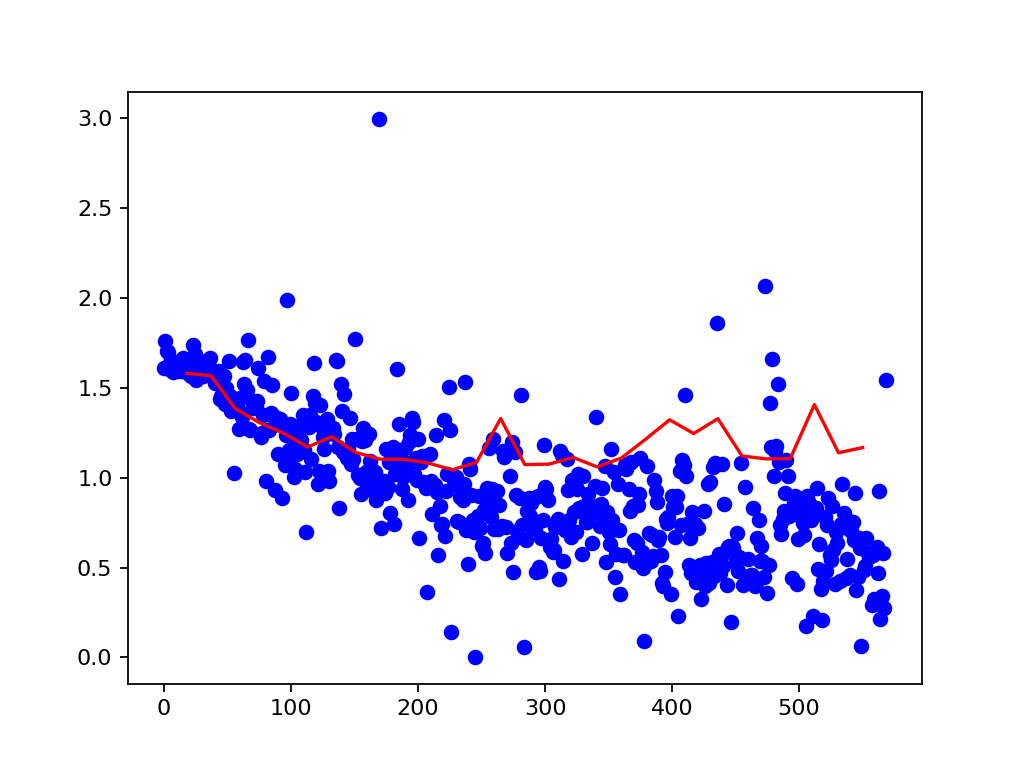

In [105]:
fig, ax = plt.subplots(1)
ax.scatter(training_step,training_loss)
ax.plot(test_step,test_loss)


fig.show()
fig.canvas.draw()

In [106]:
# Training
EPOCH = 30

torch.autograd.set_detect_anomaly(True)

for epoch in range(EPOCH):

        
    for idx, (img, label) in enumerate(train_loader): 

        # Load onto compute device
        img = img.to(device)
        label = label.to(device)
    
        y_pred = model(img)
        
        loss = error(y_pred, label)
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        training_loss.append(float(loss))
        training_step.append(global_step)
        
        global_step += 1;
        
        ax.clear()
        ax.scatter(training_step, training_loss,c="blue")
        ax.plot(test_step, test_loss,c='r')
        fig.canvas.draw()
        
    with torch.no_grad():
        for i, (test_img, test_label) in enumerate(test_loader):
            test_img = test_img.to(device)
            test_label = test_label.to(device)

            test_pred = model(test_img)
            _test_loss = error(test_pred, test_label)

            print(float(_test_loss))
            
            test_loss.append(float(_test_loss))
            test_step.append(global_step)

            global_step += 1;

        print(f'EPOCH: {epoch} / BATCH: {idx} ==> LOSS: {float(loss)}')

plt.plot(loss_array)

1.5801918506622314
EPOCH: 0 / BATCH: 17 ==> LOSS: 1.6412101984024048
1.5673415660858154
EPOCH: 1 / BATCH: 17 ==> LOSS: 1.6676288843154907
1.384952187538147
EPOCH: 2 / BATCH: 17 ==> LOSS: 1.024026870727539
1.3062735795974731
EPOCH: 3 / BATCH: 17 ==> LOSS: 1.6111794710159302
1.2474346160888672
EPOCH: 4 / BATCH: 17 ==> LOSS: 0.8869306445121765
1.170462727546692
EPOCH: 5 / BATCH: 17 ==> LOSS: 0.6965359449386597
1.228127121925354
EPOCH: 6 / BATCH: 17 ==> LOSS: 1.2509610652923584
1.1400986909866333
EPOCH: 7 / BATCH: 17 ==> LOSS: 1.7700731754302979
1.1030689477920532
EPOCH: 8 / BATCH: 17 ==> LOSS: 2.995730400085449
1.102418303489685
EPOCH: 9 / BATCH: 17 ==> LOSS: 1.0037468671798706
1.0809379816055298
EPOCH: 10 / BATCH: 17 ==> LOSS: 0.36309686303138733
1.0438369512557983
EPOCH: 11 / BATCH: 17 ==> LOSS: 0.13833245635032654
1.0848140716552734
EPOCH: 12 / BATCH: 17 ==> LOSS: 0.003941387869417667
1.3294230699539185
EPOCH: 13 / BATCH: 17 ==> LOSS: 0.8478277325630188
1.0726815462112427
EPOCH: 14 / B

NameError: name 'loss_array' is not defined

<IPython.core.display.Javascript object>


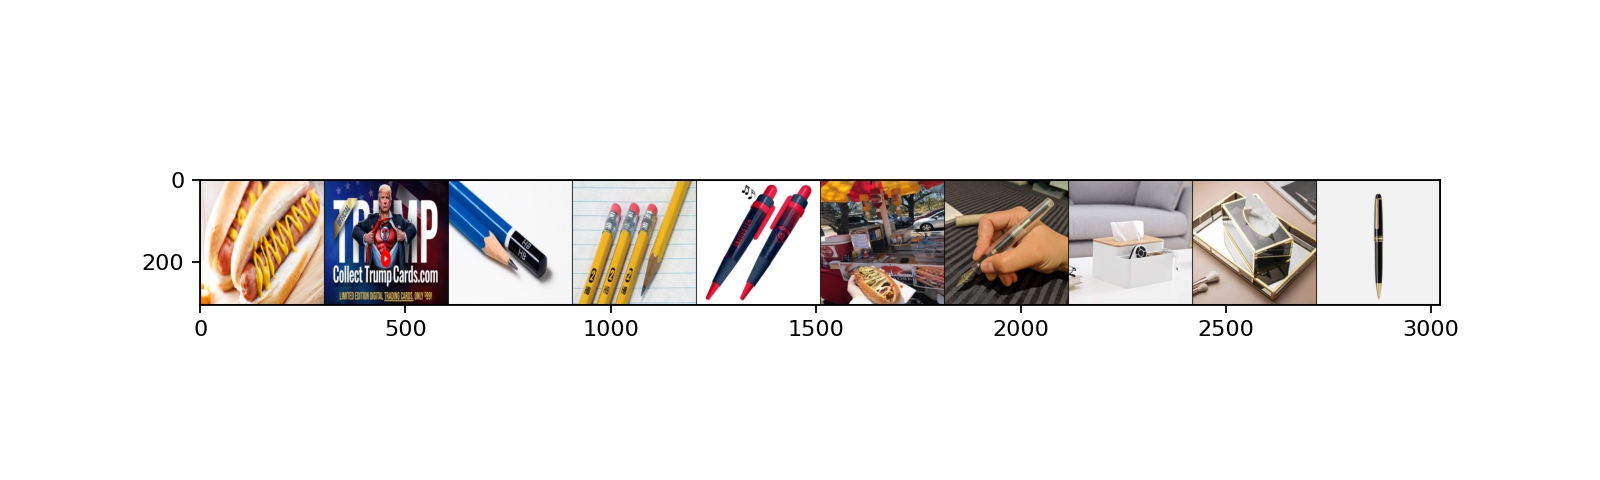

ACTUAL / PREDICTED ==> hotdog/hotdog
ACTUAL / PREDICTED ==> card/card
ACTUAL / PREDICTED ==> pencil/pencil
ACTUAL / PREDICTED ==> pencil/pencil
ACTUAL / PREDICTED ==> pen/card
ACTUAL / PREDICTED ==> hotdog/hotdog
ACTUAL / PREDICTED ==> pen/tissue_box
ACTUAL / PREDICTED ==> tissue_box/pen
ACTUAL / PREDICTED ==> tissue_box/tissue_box
ACTUAL / PREDICTED ==> pencil/pen


In [111]:
batch = next(iter(test_loader))
imgs, labels = batch

imgs = imgs.to(device)
y_pred = model(imgs)

labels.numpy()
y_pred = y_pred.cpu().detach().numpy()

grid = torchvision.utils.make_grid(imgs.cpu().detach(), nrow=10)
plt.figure(figsize=(10,3))
plt.imshow(np.transpose(grid, (1, 2, 0)))

for idx, pred in enumerate(y_pred):
    prediction = decode_onehot(pred, CATEGORIES)
    label = decode_onehot(labels[idx], CATEGORIES)
    print(f'ACTUAL / PREDICTED ==> {label}/{prediction}')

In [ ]:
np.max(loss_array[-30]) 